In [ ]:
import pandas as pd
!pip install -q --upgrade transformers


In [ ]:
df = pd.read_csv("train.csv", on_bad_lines='skip', quoting=3, encoding='utf-8')
df.head(10)

,"""id""","""comment_text""","""toxic""","""severe_toxic""","""obscene""","""threat""","""insult""","""identity_hate"""
0,"""0000997932d777bf""","""Explanation",NaN,NaN,NaN,NaN,NaN,NaN
1,Why the edits made under my username Hardcore ...,just closure on some GAs after I voted at New...,0,0,0,0,0,0
2,"""0001b41b1c6bb37e""","""""""",NaN,NaN,NaN,NaN,NaN,NaN
3,More,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I can't make any real suggestions on improveme...,"or a subsection of """"""""types of accidents""""""""...",if no-one else does first - if you have any p...,NaN,NaN,NaN,NaN,NaN
5,There appears to be a backlog on articles for ...,0,0,0,0,0,0,NaN
6,"""00025465d4725e87""","""""""",NaN,NaN,NaN,NaN,NaN,NaN
7,Congratulations from me as well,"use the tools well. · talk """"""",0,0,0,0,0,0
8,"""0002bcb3da6cb337""","""COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK""",1,1,1,0,1,0
9,"""00040093b2687caa""","""alignment on this subject and which are contr...",0,0,0,0,0,0


In [ ]:
df.columns

Index(['"id"', '"comment_text"', '"toxic"', '"severe_toxic"', '"obscene"',
       '"threat"', '"insult"', '"identity_hate"'],
      dtype='object')

In [ ]:
df.columns = df.columns.str.replace('"','').str.strip()


In [ ]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Convert columns to numeric (errors='coerce' turns bad values into NaN)
for col in label_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=label_cols).reset_index(drop=True)

In [ ]:
# Clean column names
df.columns = df.columns.str.replace('"', '').str.strip()

# Drop the ID column if it's no longer needed
df = df.drop(columns=['id'])


In [ ]:
print(df[label_cols].sum())


toxic            393.0
severe_toxic      43.0
obscene          207.0
threat            12.0
insult           190.0
identity_hate     36.0
dtype: float64


In [ ]:
print(df.shape)
print(df.isnull().sum())
print(df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum())


(3424, 7)
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
toxic            393.0
severe_toxic      43.0
obscene          207.0
threat            12.0
insult           190.0
identity_hate     36.0
dtype: float64


## **Visualization**

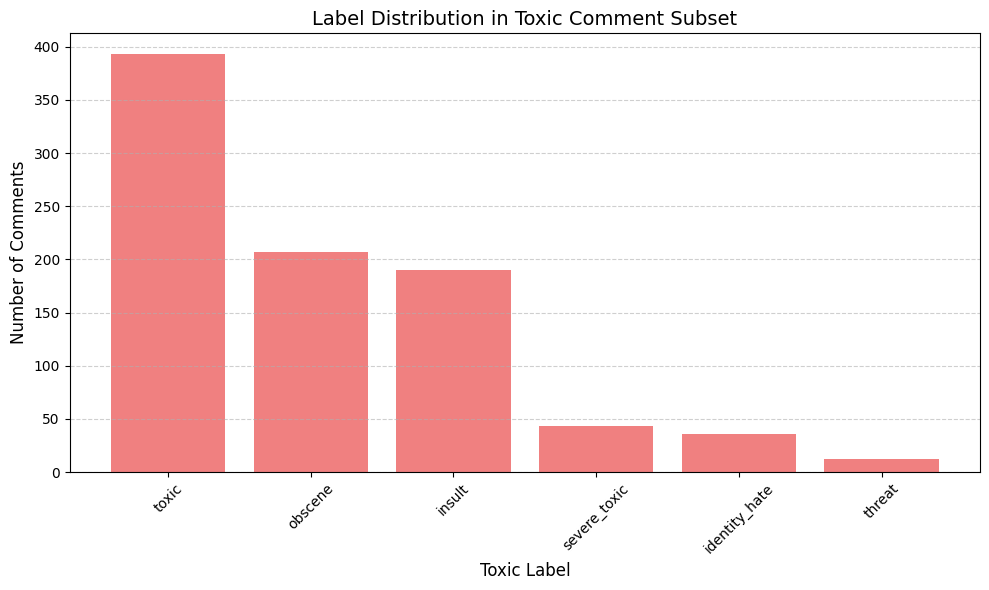

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define label columns
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Step 2: Sum each label from your cleaned DataFrame
label_counts = df[label_cols].sum().astype(int).to_dict()

# Step 3: Convert to DataFrame for plotting
df_counts = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count'])
df_counts = df_counts.sort_values('count', ascending=False)

# Step 4: Plot
plt.figure(figsize=(10, 6))
plt.bar(df_counts.index, df_counts['count'], color='lightcoral')
plt.title('Label Distribution in Toxic Comment Subset', fontsize=14)
plt.xlabel('Toxic Label', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### **After Normalization**

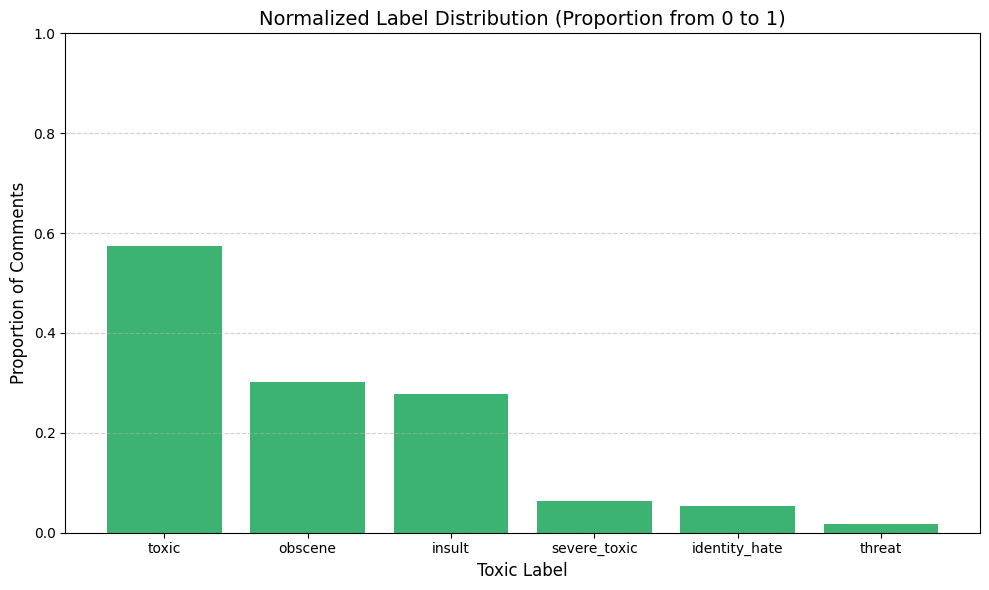

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

label_counts = df[label_cols].sum()

normalized_counts = (label_counts / len(df))

# Create DataFrame
df_norm = pd.DataFrame({
    'label': normalized_counts.index,
    'normalized_value': normalized_counts.values
}).sort_values('normalized_value', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(df_norm['label'], df_norm['normalized_value'], color='mediumseagreen')
plt.title('Normalized Label Distribution (Proportion from 0 to 1)', fontsize=14)
plt.xlabel('Toxic Label', fontsize=12)
plt.ylabel('Proportion of Comments', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## **Base line Model(Without any futher cleanning)**

In [ ]:
import torch
from sklearn.model_selection import train_test_split

import torch
from sklearn.model_selection import train_test_split

# Define label columns
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Input and target
X = df['comment_text'].tolist()
y = df[label_cols].values

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from transformers import AutoTokenizer

# Tokenization & Dataset Class

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

MAX_LEN = 128

def tokenize(texts):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

class ToxicCommentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenize(texts)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Create datasets
train_dataset = ToxicCommentDataset(X_train, y_train)
val_dataset = ToxicCommentDataset(X_val, y_val)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_cols),
    problem_type="multi_label_classification"
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import transformers
print(transformers.__version__)

4.54.0


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
Tesla T4


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_dir="./logs",
    logging_steps=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,0.012700,0.079371


TrainOutput(global_step=343, training_loss=0.12883650288854673, metrics={'train_runtime': 34.1833, 'train_samples_per_second': 80.127, 'train_steps_per_second': 10.034, 'total_flos': 90713521755648.0, 'train_loss': 0.12883650288854673, 'epoch': 1.0})

In [ ]:
print(len(train_dataset), len(val_dataset))


2739 685


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import torch

# Step 1: Get model predictions on validation set
preds = trainer.predict(val_dataset)

# Step 2: Apply sigmoid to get probabilities from raw logits
probs = torch.sigmoid(torch.tensor(preds.predictions)).numpy()

# Step 3: Convert probs to binary (default threshold = 0.5)
pred_labels = (probs > 0.5).astype(int)

# Step 4: Print classification report
print(classification_report(y_val, pred_labels, target_names=label_cols))


               precision    recall  f1-score   support

        toxic       0.71      0.73      0.72        74
 severe_toxic       0.00      0.00      0.00         8
      obscene       0.57      0.88      0.69        34
       threat       0.00      0.00      0.00         2
       insult       0.53      0.71      0.61        34
identity_hate       0.00      0.00      0.00        11

    micro avg       0.62      0.66      0.64       163
    macro avg       0.30      0.39      0.34       163
 weighted avg       0.55      0.66      0.60       163
  samples avg       0.06      0.07      0.06       163



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

This notebook presents a baseline toxic comment classification model using DistilBERT on the Jigsaw dataset. After cleaning and tokenizing the data, a multi-label classifier was trained to detect six types of toxic language. The model performed well on common labels like "toxic" and "obscene," but struggled with rare ones such as "threat" and "identity_hate" due to class imbalance. Evaluation metrics showed solid micro F1 but low macro F1, highlighting the need for improvement. Future steps include applying class weights, threshold tuning, and visualization to boost performance on underrepresented categories.